# IGA-sequencing figures

1. Donor and patient IGA labelling is correlated
2. IGA log fold change versus overall abundance
3. Variance of IGA-seq versus abudance
4. Itol tree with categories
    1. Generally IGA+
    2. Generally IGA–
    3. Mixed IGA– IGA+ across patients
    4. Variable IGA– IGA+ within patients
    5. Generally neutral

In [1]:
import itertools
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.spatial.distance as dist
from io import StringIO
from skbio import TreeNode
from matplotlib.lines import Line2D
import statsmodels.stats.multitest as multitest
from matplotlib.patches import Patch

sns.set_style('white')
%matplotlib inline

In [2]:
#get patient colors
dd_pat_col = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
              '004': (1.0, 0.4980392156862745, 0.054901960784313725),
              '005': (1.0, 0.7333333333333333, 0.47058823529411764),
              '006': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
              '007': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
              '008': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
              '009': (1.0, 0.596078431372549, 0.5882352941176471),
              '010': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
              '011': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
              '012': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
              '013': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
              '014': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}
dd_pat_col_name = {'patient_' + str(k): v for k, v in dd_pat_col.items()}

In [3]:
def read_fasta_tuple(fastafile):
    """(file) -> list
    Reads fasta file and returns list of lists of [[label, sequence]]
    The resulting labels do not include ">". Neither the label or sequence
    will include newline characters.
    """
    with open(fastafile) as f:
        read = f.read().split("\n>")
        read[0] = read[0][1:] #account for first read ">"
        entries = [seq.partition("\n") for seq in read]
        return [[seq[0][0:], seq[2].replace("\n", "")] for seq in entries]

def relative_abundance_tidy(df, sample_col, value_col,
                            rel_abun_name='rel_abun'):
    """
    Take a tidy table, where the samples are in sample_col and the values
    to be converted to relative abundance are in value_col.
    
    sample_col can also be a list of columns
    """
    #define relatibe abundance calculation
    rel_abun = lambda x: (x / x.sum())
    #calculate new values
    values = df.groupby(sample_col)[value_col].transform(rel_abun)
    values = values.rename(rel_abun_name)
    #add to df and return
    df = pd.concat([df, values], axis=1)
    return df

In [4]:
#read in metadata
md = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_stool_dna_NV022018.tsv',
                 sep='\t', dtype={'patient': 'object',
                                  'fmt': 'object',
                                  'fmt_induction': 'object'})
md.loc[:, 'patient_plt'] = 'patient_' + md['patient']

#read in patient metadata
md_pat = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_patients_2019-04-10.tsv',
                     sep='\t', dtype={'patient': 'object',
                                      'fmt': 'object',
                                      'fmt_induction': 'object'})

In [5]:
pat_id_dict = md_pat.set_index('patient').to_dict()['label_pub']

In [6]:
#read in metadata
md_iga = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_iga_OC162018.tsv',
                 sep='\t', dtype={'patient': 'object',
                                  'fmt': 'object', 
                                  'fmt_induction': 'object'})
md_iga_flat = md_iga[['sample_stool', 'patient', 'days_past_fmt', 'approx_wk',
                     'treatment', 'fmt_induction', 'clinical_response']].drop_duplicates()
iga = pd.read_csv('/Users/ndchu/Documents/uc_fmt/iga_seq/deblur_emp_OC042018/otu_tab_f.tsv',
                  sep='\t', index_col=0).astype(int)
iga_16s =  pd.read_csv('/Users/ndchu/Documents/uc_fmt/iga_seq/iga_16S/otu_tab_f.tsv',
                  sep='\t', index_col=0).astype(int)
otu = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/dd_asv_tab_f.tsv',
                  sep='\t', index_col=0).astype(int)
taxa = pd.read_csv('/Users/ndchu/Documents/uc_fmt/iga_seq/deblur_emp_OC042018/taxonomy.tsv',
                      sep='\t')
taxa[['domain', 'phylum', 'class',
      'order', 'family', 'genus',
      'species']] = taxa['Taxon'].str.split(';', expand=True)

#read log change data
log_chg = pd.read_csv('/Users/ndchu/Documents/uc_fmt/iga_seq/debe_logchg_posneg_persample_OC162018.tsv.gz',
                      sep='\t', compression='gzip')
log_chg_iga_16s = pd.read_csv('/Users/ndchu/Documents/uc_fmt/iga_seq/iga_16S/iga_pos_logchg.tsv.gz',
                              sep='\t', compression='gzip')

#read in sequence information
iga_fa = read_fasta_tuple('/Users/ndchu/Documents/uc_fmt/iga_seq/deblur_emp_OC042018/dna-sequences.fasta')
iga_16s_fa = read_fasta_tuple('/Users/ndchu/Documents/uc_fmt/iga_seq/iga_16S/dna-sequences.fasta')

#make tidy data
iga_tidy = pd.melt(iga.reset_index(), id_vars='#OTU ID',
                   var_name='sample_iga_stool', value_name='count')
iga_16s_tidy = pd.melt(iga_16s.reset_index(), id_vars='#OTU ID',
                       var_name='sample_mimarks', value_name='count')

#add relative abundance
iga_tidy = relative_abundance_tidy(iga_tidy, 'sample_iga_stool', 'count')
iga_16s_tidy = relative_abundance_tidy(iga_16s_tidy, 'sample_mimarks', 'count')

#add metadata
iga_tidy = iga_tidy.merge(md_iga)
tmp_md = pd.concat([md_iga, md])
iga_16s_tidy = iga_16s_tidy.merge(tmp_md)

#add metadata to log fold change
log_chg = log_chg.merge(md_iga, how='outer')
log_chg_iga_16s = log_chg_iga_16s.merge(md_iga, how='outer')

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [9]:
#get log change dataframe without sample duplicates
log_chg_cl = log_chg[['#OTU ID', 'sample_stool', 'log2_fold_chg_abun', 
                      'patient', 'patient_donor', 'days_past_fmt', 
                      'approx_wk', 'treatment', 'fmt_induction',
                      'clinical_response']].drop_duplicates()

In [10]:
#read in 499 newick tree
with open('/Users/ndchu/Documents/uc_fmt/iga_seq/deblur_emp_OC042018/tree_499.nwk') as nwk:
    tree499 = TreeNode.read(StringIO(nwk.readlines()[0].rstrip()))

In [11]:
#get overall log-fold change for each otu
log_chg_dropdup = log_chg[['#OTU ID', 
                           'sample_stool', 
                           'patient',
                           'log2_fold_chg_abun']]
log_chg_dropdup = log_chg_dropdup.drop_duplicates()

#get the mean for each patient
log_chg_dropdup_patmean = log_chg_dropdup.groupby(['#OTU ID', 'patient']).mean().reset_index()

#let's look at the correlation between the donors
log_chg_ftab = log_chg_dropdup.pivot(index='#OTU ID', 
                                     columns='sample_stool', 
                                     values='log2_fold_chg_abun')

## Correlation of donor to patients

In [10]:
mean_logchg_pp = log_chg.groupby(['patient', '#OTU ID']).mean().reset_index()

In [11]:
#get feature table
donor_plt = mean_logchg_pp.pivot(index='#OTU ID', 
                                 columns='patient', 
                                 values='log2_fold_chg_abun')
#get column of mean from patients
pats = ['007', '008', '009', '010', '011', '012', '013', '014']
donor_plt.loc[:, 'patient_mean'] = donor_plt[pats].mean(axis=1)
pats_plt = ['007', '008', '010', '011', '014', '009', '012', '013']

In [12]:
#get also the plot for patient by patient means
donor_plt_bypat = []
for pat in pats:
    tmp = donor_plt[['0044', pat]].rename(columns={pat: 'patient_values'})
    donor_plt_bypat.append(tmp)
donor_plt_bypat = pd.concat(donor_plt_bypat)

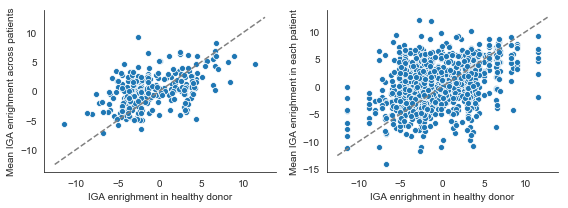

In [150]:
#plot donor mean versus patient mean
fig = plt.figure(figsize = (8,3))

ax1 = fig.add_subplot(1,2,1)
sns.scatterplot(x='0044', y='patient_mean', data=donor_plt)
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 
         color='grey', ls='--')

ax1.set_xlabel('IGA enrichment in healthy donor')
ax1.set_ylabel('Mean IGA enrichment across patients')


ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x='0044', y='patient_values', data=donor_plt_bypat)
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 
         color='grey', ls='--')

ax2.set_xlabel('IGA enrichment in healthy donor')
ax2.set_ylabel('Mean IGA enrichment in each patient')

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/2019-03-04.iga_donor_patients.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/2019-03-04.iga_donor_patients.pdf',
            dpi=300)

### Plot donor versus mean baseline and each individual patient

In [13]:
#make ftab of baseline values for patients
log_chg_bl = log_chg.loc[log_chg['days_past_fmt'] < -5][['patient', 
                                                         '#OTU ID', 
                                                         'log2_fold_chg_abun']]
log_chg_bl = log_chg_bl.drop_duplicates()

log_chg_bl_ftab = log_chg_bl.pivot(index='#OTU ID', 
                                   columns='patient', 
                                   values='log2_fold_chg_abun')

#add for mean values from donor
d44_mean_ftab = donor_plt['0044']
log_chg_bl_ftab = pd.concat([log_chg_bl_ftab, d44_mean_ftab], axis=1)

#drop all nans
log_chg_bl_ftab = log_chg_bl_ftab.dropna(axis=0, how='all')

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [14]:
#add a column for mean across all patients
log_chg_bl_ftab.loc[:, 'mean_patient_bl'] = log_chg_bl_ftab[pats].mean(axis=1)

In [15]:
#get pearson for all pats at baseline
pearsonbl = []
for pat in pats_plt:
    tmp = log_chg_bl_ftab[[pat, '0044']].dropna()
    pearsonr = stats.pearsonr(x=tmp[pat], 
                              y=tmp['0044'])[0]
    pearsonbl.append([pat, pearsonr])
pearsonbl_df = pd.DataFrame(pearsonbl, columns=['patient', 'pearson'])

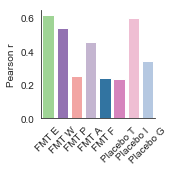

In [18]:
fig = plt.figure(figsize = (2.5,2.5))
ax = sns.barplot(x='patient', y='pearson',
                 data=pearsonbl_df,
                 palette=dd_pat_col,
                )
ax.set_xticklabels([pat_id_dict[x] for x in pats_plt])
ax.set_xlabel('')
ax.set_ylabel('Pearson r')
ax.tick_params(axis='x', rotation=45)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/iga_dnrbl_pearson_2019-04-17.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/iga_dnrbl_pearson_2019-04-17.pdf',
            dpi=300)

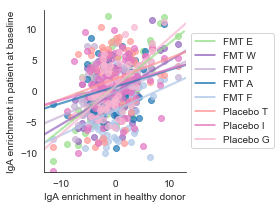

In [21]:
#for each patient plot the correlation
fig = plt.figure(figsize = (4,3))

for pat in pats_plt:
    ax = sns.regplot(x=log_chg_bl_ftab['0044'],
                     y=log_chg_bl_ftab[pat],
                     scatter_kws={'alpha':0.7},
                     line_kws={'alpha':0.7},
                     ci=False,
                     color=dd_pat_col[pat]
                    )

ax.set_xlim(-13, 13)
ax.set_ylim(-13, 13)
ax.set_xlabel('IgA enrichment in healthy donor')
ax.set_ylabel('IgA enrichment in patient at baseline')

#make legend
legend_elements = [Line2D([0], 
                          [0], 
                          color=dd_pat_col[x], 
                          label=pat_id_dict[x])
                   for x in pats_plt]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/iga_dnrbl_bypat_2019-04-17.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/iga_dnrbl_bypat_2019-04-17.pdf',
            dpi=300)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


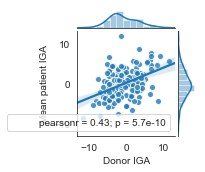

In [76]:
#let's also get the correlation of the donor samples
g = sns.jointplot(x=log_chg_bl_ftab['0044'], y=log_chg_bl_ftab['mean_patient_bl'],
                  kind="reg", height=2.5, xlim=(-13, 13), ylim=(-13, 13), 
                  scatter_kws={'linewidth': 1, 'edgecolors': 'white'})
g.set_axis_labels('Donor IGA', 'Mean patient IGA')
g = g.annotate(stats.pearsonr, loc="lower right")

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/iga_dnr_meanbl_2019-04-17.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/iga_dnr_meanbl_2019-04-17.pdf',
            dpi=300)

### Plot donor against other donor sample

In [11]:
donor_plt_nonan = donor_plt[['0044', 'patient_mean']].dropna()
donor_plt_bypat_nonan = donor_plt_bypat[['0044', 'patient_values']].dropna()
print(stats.spearmanr(donor_plt_nonan['0044'], 
                      donor_plt_nonan['patient_mean']))
print(stats.spearmanr(donor_plt_bypat_nonan['0044'], 
                      donor_plt_bypat_nonan['patient_values']))

SpearmanrResult(correlation=0.45704986031767836, pvalue=4.955532582952723e-15)
SpearmanrResult(correlation=0.3450049261890443, pvalue=8.717326646317736e-36)


/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


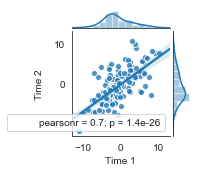

In [16]:
#let's also get the correlation of the donor samples
g = sns.jointplot(x=log_chg_ftab['0044-0025'], y=log_chg_ftab['0044-0070'],
                  kind="reg", height=2.5, xlim=(-13, 13), ylim=(-13, 13), 
                  scatter_kws={'linewidth': 1, 'edgecolors': 'white'})
g.set_axis_labels('Time 1', 'Time 2')
g = g.annotate(stats.pearsonr, loc="lower right")

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/iga_donorcorr_2019-04-17.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/iga_donorcorr_2019-04-17.pdf',
            dpi=300)

In [85]:
tmp = pd.concat([log_chg_ftab['0044-0025'], 
                 log_chg_ftab['0044-0070']], axis=1).dropna()
stats.pearsonr(tmp['0044-0025'], tmp['0044-0070'])

(0.6978922353496848, 1.4111405820589585e-26)

## IGA versus abundance

For this, we'll use the combined analysis results. NOTE THAT THESE DO NOT INCLUDE DONOR 0044 BECAUSE THOSE SAMPLES DID NOT OVERLAP.

In [22]:
#make psudeo count columns
iga_16s_tidy.loc[:, 'count_ps'] = iga_16s_tidy['count'] + 1
iga_16s_tidy = relative_abundance_tidy(iga_16s_tidy, 'sample_mimarks', 
                                       'count_ps', rel_abun_name='rel_abun_ps')

In [23]:
#get only 16S samples
iga_16s_tidy_16S = iga_16s_tidy.loc[iga_16s_tidy['gate'].isnull()][['#OTU ID', 
                                                                    'sample_id',
                                                                    'patient',
                                                                    'rel_abun',
                                                                    'rel_abun_ps']]
#get also the log abunance
iga_16s_tidy_16S.loc[:, 'log_rel_abun'] = np.log10(iga_16s_tidy_16S['rel_abun_ps'])

#get overall log-fold change for each otu
log_chg_iga_16s_sum = log_chg_iga_16s[['#OTU ID', 
                                       'sample_stool', 
                                       'patient',
                                       'log2_fold_chg_abun']]
log_chg_iga_16s_sum = log_chg_iga_16s_sum.drop_duplicates()

#merge these tables
relabun_v_iga_df = log_chg_iga_16s_sum.merge(iga_16s_tidy_16S, 
                                             left_on=['#OTU ID', 
                                                      'sample_stool', 
                                                      'patient'],
                                             right_on=['#OTU ID', 
                                                       'sample_id',
                                                       'patient'])

In [24]:
#also get a mean from each patient over all samples
relabun_v_iga_mean_df = relabun_v_iga_df.groupby(['patient', '#OTU ID']).mean().reset_index()

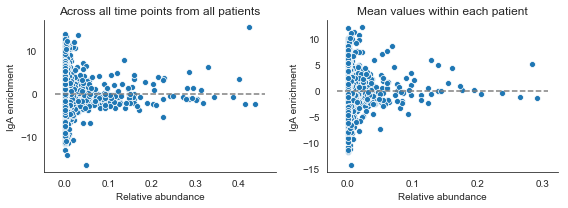

In [26]:
#plot abundance versus IGA
fig = plt.figure(figsize = (8,3))

ax1 = fig.add_subplot(1,2,1)
sns.scatterplot(x='rel_abun', y='log2_fold_chg_abun', 
                data=relabun_v_iga_df)
ax1.plot(ax1.get_xlim(), [0, 0], 
         color='grey', ls='--')

ax1.set_xlabel('Relative abundance')
ax1.set_ylabel('IgA enrichment')
ax1.set_title('Across all time points from all patients')


ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x='rel_abun', y='log2_fold_chg_abun', 
                data=relabun_v_iga_mean_df)
ax2.plot(ax2.get_xlim(), [0, 0], 
         color='grey', ls='--')

ax2.set_xlabel('Relative abundance')
ax2.set_ylabel('IgA enrichment')
ax2.set_title('Mean values within each patient')

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/iga_relabun_2019-05-06.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/iga_relabun_2019-05-06.pdf',
            dpi=300)

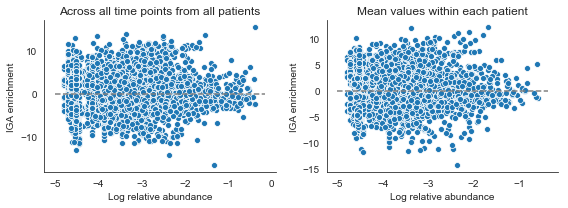

In [169]:
#plot log abundance versus IGA
fig = plt.figure(figsize = (8,3))

ax1 = fig.add_subplot(1,2,1)
sns.scatterplot(x='log_rel_abun', y='log2_fold_chg_abun', 
                data=relabun_v_iga_df)
ax1.plot(ax1.get_xlim(), [0, 0], 
         color='grey', ls='--')

ax1.set_xlabel('Log relative abundance')
ax1.set_ylabel('IGA enrichment')
ax1.set_title('Across all time points from all patients')


ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x='log_rel_abun', y='log2_fold_chg_abun', 
                data=relabun_v_iga_mean_df)
ax2.plot(ax2.get_xlim(), [0, 0], 
         color='grey', ls='--')

ax2.set_xlabel('Log relative abundance')
ax2.set_ylabel('IGA enrichment')
ax2.set_title('Mean values within each patient')

sns.despine()
plt.tight_layout()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/2019-03-05.iga_relabun.png',
#            dpi=300)
#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/2019-03-05.iga_donor.pdf',
#            dpi=300)

In [170]:
def plot_freq_comp_hex(x_series, y_series, log_axes=True, bin_method=None,
                       gridsize=30, spearman=True):
    """
    Takes two series, which are assumed to be the same type of values and 
    plot the two against each other.
    
    The two series either must have identical indexes OR have indexes that
    are related, and thus comparison of each index is valid
    
    ONLY shared elements will be used for the plot and stats. Elements in
    one series that are abset from the other are ignored.
    
    Log will plot both axes using a log scale
    Spearman will report the # of shared elements, spearman rho, and p val
    Return axes will return the axes object
    """
    #merge series, removing missing values
    tmp_table = pd.concat([x_series, y_series], axis=1, join='inner')
    tmp_table = tmp_table.dropna() #drop nans
    
    #plotting parameters
    if log_axes:
        xscale = 'log'
        yscale = 'log'
    else:
        xscale = 'linear'
        yscale = 'linear'
    
    #plot_extents = (-7, -3, -7, -3)#hard set for plotting
    
    #start plotting
    plt.hexbin(tmp_table.iloc[:, 0].values, tmp_table.iloc[:, 1].values,
               gridsize=gridsize, cmap='PuBu', xscale=xscale, yscale=yscale, 
               bins=bin_method)#, extent=plot_extents)
    
    #plt.xlim(x_series.min(), x_series.max())
    #plt.ylim(y_series.min(), y_series.max())
    
    sns.despine()
    
    #calculate spearman correlation and report
    if spearman:
        rho, pval = stats.spearmanr(tmp_table.iloc[:, 0].values,
                                    tmp_table.iloc[:, 1].values)
        print('shared elements = {0}, rs = {1:.5f}, p = {2:.5f}'.format(len(tmp_table),
                                                                        rho,
                                                                        pval))

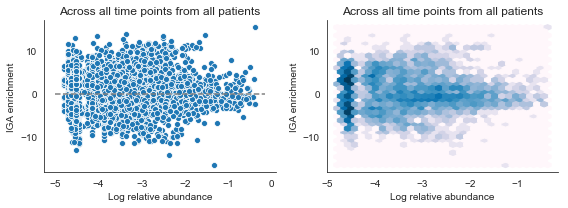

In [174]:
#plot log abundance versus IGA
fig = plt.figure(figsize = (8,3))

ax1 = fig.add_subplot(1,2,1)
sns.scatterplot(x='log_rel_abun', y='log2_fold_chg_abun', 
                data=relabun_v_iga_df)
ax1.plot(ax1.get_xlim(), [0, 0], 
         color='grey', ls='--')

ax1.set_xlabel('Log relative abundance')
ax1.set_ylabel('IGA enrichment')
ax1.set_title('Across all time points from all patients')


ax2 = fig.add_subplot(1,2,2)
plot_freq_comp_hex(relabun_v_iga_df['log_rel_abun'], 
                   relabun_v_iga_df['log2_fold_chg_abun'],
                   log_axes=False,
                   bin_method='log',
                   spearman=False)

ax2.set_xlabel('Log relative abundance')
ax2.set_ylabel('IGA enrichment')
ax2.set_title('Across all time points from all patients')

sns.despine()
plt.tight_layout()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/2019-03-05.iga_relabun.png',
#            dpi=300)
#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/2019-03-05.iga_donor.pdf',
#            dpi=300)

## IGA versus variance


In [27]:
#get variance of each otu in each patient across all samples, IGA or not
iga_16s_var = iga_16s_tidy_16S.groupby(['patient', '#OTU ID']).var().reset_index()

#remove any entries where the relative abundance variance is zero (i.e. always zero)
iga_16s_var = iga_16s_var.loc[iga_16s_var['rel_abun'] > 0]

#rename
iga_16s_var = iga_16s_var.rename(columns={'rel_abun': 'rel_abun_var',
                                          'rel_abun_ps': 'rel_abun_ps_var',
                                          'log_rel_abun': 'log_rel_abun_var'})

In [28]:
#merge with mean IGA variance for each patient
iga_16s_var_mean = iga_16s_var.groupby(['patient', '#OTU ID']).mean().reset_index()
log_chg_iga_16s_mean = log_chg_iga_16s_sum.groupby(['patient', 
                                                    '#OTU ID']).mean().reset_index()

var_v_iga_mean_df = log_chg_iga_16s_mean.merge(iga_16s_var_mean, 
                                             left_on=['#OTU ID', 
                                                      'patient'],
                                             right_on=['#OTU ID', 
                                                       'patient'])

#merge with mean IGA for each sample
var_v_iga_persam_df = log_chg_iga_16s_sum.merge(iga_16s_var_mean, 
                                             left_on=['#OTU ID', 
                                                      'patient'],
                                             right_on=['#OTU ID', 
                                                       'patient'])

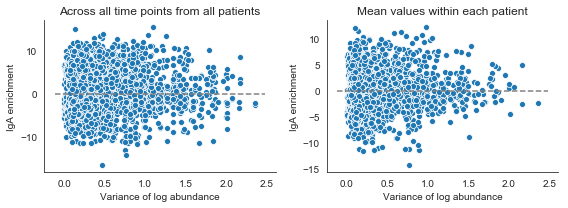

In [29]:
#plot abundance versus IGA
fig = plt.figure(figsize = (8,3))

ax1 = fig.add_subplot(1,2,1)
sns.scatterplot(x='log_rel_abun_var', y='log2_fold_chg_abun', 
                data=var_v_iga_persam_df)
ax1.plot(ax1.get_xlim(), [0, 0], 
         color='grey', ls='--')

ax1.set_xlabel('Variance of log abundance')
ax1.set_ylabel('IgA enrichment')
ax1.set_title('Across all time points from all patients')


ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x='log_rel_abun_var', y='log2_fold_chg_abun', 
                data=var_v_iga_mean_df)
ax2.plot(ax2.get_xlim(), [0, 0], 
         color='grey', ls='--')

ax2.set_xlabel('Variance of log abundance')
ax2.set_ylabel('IgA enrichment')
ax2.set_title('Mean values within each patient')

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/iga_variance_2019-05-06.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/iga_variance_2019-05-06.pdf',
            dpi=300)

## ITOL categories

Itol tree with categories

1. Generally IGA+
2. Generally IGA–
3. Mixed IGA– IGA+ across patients
4. Variable IGA– IGA+ within patients
5. Generally neutral

In [63]:
def ttest_zero(in_series, p_thresh):
    """
    Returns 'pos' if the values in in_series are significantly greater than 0
            'neg' if the values in in_series are significantly less than 0
            'None' if the values in in_series are not significnatly different than 0
    Uses p_thresh to determine significance
    """
    ttest = stats.ttest_1samp(in_series, 0)
    if ttest[1] <= p_thresh:
        if ttest[0] > 0:
            return 'pos'
        elif ttest[0] < 0:
            return 'neg'
    else:
        return None

def ttest_zero_vals(in_series):
    """
    Returns t-test statistic and p value, comparing the series to
    a mean of zero
    """
    ttest = stats.ttest_1samp(in_series, 0)
    return pd.Series([ttest[0], ttest[1]], index=['t_stat', 'p'])

def fdr_ttest_cat(in_series):
    """
    Returns category for fdr adjusted p values
    """
    threshold = 0.1
    if in_series['fdr'] <= threshold:
        if in_series['t_stat'] > 0:
            return 'pos'
        elif in_series['t_stat'] < 0:
            return 'neg'
    else:
        return None

In [11]:
#get overall log-fold change for each otu
log_chg_dropdup = log_chg[['#OTU ID', 
                           'sample_stool', 
                           'patient',
                           'log2_fold_chg_abun']]
log_chg_dropdup = log_chg_dropdup.drop_duplicates()

#get the mean for each patient
log_chg_dropdup_patmean = log_chg_dropdup.groupby(['#OTU ID', 'patient']).mean().reset_index()

In [12]:
#get significantly IGA+ or IGA– OTUs across all samples
ttest_cat_psam = log_chg_dropdup.groupby('#OTU ID')['log2_fold_chg_abun'].apply(ttest_zero_vals).reset_index()

ttest_cat_psam = ttest_cat_psam.rename(columns={'level_1': 'var', 
                                      'log2_fold_chg_abun': 'value'})
ttest_cat_psam = ttest_cat_psam.pivot(index='#OTU ID', columns='var', values='value')
#drop nans
ttest_cat_psam = ttest_cat_psam.loc[ttest_cat_psam['p'].notnull()]
#get FDR adjusted pvalues
ttest_cat_psam.loc[:, 'fdr'] = multitest.fdrcorrection(ttest_cat_psam['p'])[1]

#do the same with mean values within each patient
ttest_cat_ppat = log_chg_dropdup_patmean.groupby('#OTU ID')['log2_fold_chg_abun'].apply(ttest_zero_vals).reset_index()

ttest_cat_ppat = ttest_cat_ppat.rename(columns={'level_1': 'var', 
                                      'log2_fold_chg_abun': 'value'})
ttest_cat_ppat = ttest_cat_ppat.pivot(index='#OTU ID', columns='var', values='value')
#drop nans
ttest_cat_ppat = ttest_cat_ppat.loc[ttest_cat_ppat['p'].notnull()]
#get FDR adjusted pvalues
ttest_cat_ppat.loc[:, 'fdr'] = multitest.fdrcorrection(ttest_cat_ppat['p'])[1]

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
#get sets of otus for each category
ttest_psam_pass = ttest_cat_psam.loc[ttest_cat_psam['fdr'] < 0.1]
otus_igap_psam = set(ttest_psam_pass.loc[ttest_psam_pass['t_stat'] > 0].index)
otus_igan_psam = set(ttest_psam_pass.loc[ttest_psam_pass['t_stat'] < 0].index)

ttest_ppat_pass = ttest_cat_ppat.loc[ttest_cat_ppat['fdr'] < 0.1]
otus_igap_ppat = set(ttest_ppat_pass.loc[ttest_ppat_pass['t_stat'] > 0].index)
otus_igan_ppat = set(ttest_ppat_pass.loc[ttest_ppat_pass['t_stat'] < 0].index)

#### Variable IGA labelling

This has two categories:

    1. OTUs with variable labelling across patients
    2. OTUs with variable labelling across time in the same patient
    
For scenario #1, we'll look for OTUs whose means in each patient can be seen both above and below 1 std dev from the mean

For scenario #2, we'll look for OTUs whose log_chg in each sample fall both above and below 1 std from the mean for that sample

In [14]:
def thresh(x, upper, lower):
    """
    Returns pos if x > upper, neg if x < lower, None otherwise
    """
    if x > upper:
        return 'pos'
    elif x < lower:
        return 'neg'
    else:
        return None

In [15]:
#get mean log fold change per patient
tmp = log_chg_dropdup.groupby(['patient', '#OTU ID']).mean().reset_index()

pos_thresh = tmp['log2_fold_chg_abun'].mean() + tmp['log2_fold_chg_abun'].std()
neg_thresh = tmp['log2_fold_chg_abun'].mean() - tmp['log2_fold_chg_abun'].std()

tmp.loc[:, 'pat_mean_std_bin'] = tmp['log2_fold_chg_abun'].apply(thresh, 
                                                                 upper=pos_thresh,
                                                                 lower=neg_thresh)

otus_mixed_acrosspat = []
for otu, sub_df in tmp.groupby('#OTU ID'):
    if 'pos' in sub_df['pat_mean_std_bin'].values:
        if 'neg' in sub_df['pat_mean_std_bin'].values:
            otus_mixed_acrosspat.append(otu)

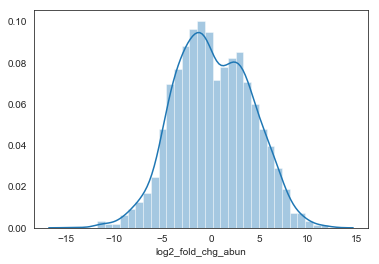

In [266]:
sns.distplot(tmp['log2_fold_chg_abun'])

In [16]:
mixed = log_chg_dropdup.copy()

#get std dev
tmp = log_chg_dropdup.groupby(['patient', 'sample_stool']).std()
tmp = tmp.rename(columns={'log2_fold_chg_abun': 'log_chg_std_psam'}).reset_index()
mixed = mixed.merge(tmp)

#get means
tmp = log_chg_dropdup.groupby(['patient', 'sample_stool']).mean()
tmp = tmp.rename(columns={'log2_fold_chg_abun': 'log_chg_mean_psam'}).reset_index()
mixed = mixed.merge(tmp)

In [17]:
def std_cat(in_series):
    if in_series['log2_fold_chg_abun'] < in_series['log_chg_mean_psam'] - in_series['log_chg_std_psam']:
        return 'neg'
    elif in_series['log2_fold_chg_abun'] > in_series['log_chg_mean_psam'] + in_series['log_chg_std_psam']:
        return 'pos'
    else:
        return None

In [18]:
#make a columne for above or below 1 std dev from the mean
mixed.loc[:, 'std_cat'] = mixed.apply(std_cat, axis=1)

In [19]:
#for each patient, otu combination, fine instances where an OTU is both pos and neg
otus_mixed_withinpat = []

for [patient, otu], sub_df in mixed.groupby(['patient', '#OTU ID']):
    if 'pos' in sub_df['std_cat'].values:
        if 'neg' in sub_df['std_cat'].values:
            otus_mixed_withinpat.append(otu)

In [307]:
len(otus_mixed_withinpat)

56

### Neutral OTUs

Which ones are never up nor down?

In [20]:
#find otus that are never up or down in any sample
otus_neutral = []

for otu, sub_df in mixed.groupby('#OTU ID'):
    if 'pos' not in sub_df['std_cat'].values:
        if 'neg' not in sub_df['std_cat'].values:
            otus_neutral.append(otu)

In [309]:
len(otus_neutral)

269

### Build itol dataset

Let's build a dataset with circles. Red for IGA+, Blue for IGA–, Dark purple for variable across patients, light purple for variable within patients, grey for neutral

In [21]:
#start dataframe
otu_499 = [x.name for x in tree499.tips()]
itol_df = pd.DataFrame(otu_499, columns=['#OTU ID'])

#add IGA+/–
itol_df.loc[:, 'IGA+_patients'] = itol_df['#OTU ID'].isin(otus_igap_ppat)
itol_df.loc[:, 'IGA+_samples'] = itol_df['#OTU ID'].isin(otus_igap_psam)
itol_df.loc[:, 'IGA–_patients'] = itol_df['#OTU ID'].isin(otus_igan_ppat)
itol_df.loc[:, 'IGA–_samples'] = itol_df['#OTU ID'].isin(otus_igan_psam)

#add variable
itol_df.loc[:, 'Variable_across_patients'] = itol_df['#OTU ID'].isin(otus_mixed_acrosspat)
itol_df.loc[:, 'Variable_within_patients'] = itol_df['#OTU ID'].isin(otus_mixed_withinpat)

#add neutral
itol_df.loc[:, 'Neutral'] = itol_df['#OTU ID'].isin(otus_neutral)

In [22]:
itol_out_df = itol_df.set_index('#OTU ID')
itol_out_df = itol_out_df.replace([True, False], [1, -1])

In [339]:
#how many otus have no features? (about half)
itol_out_df.loc[~(itol_out_df == -1).all(axis=1)].shape

(241, 7)

In [342]:
itol_out_df.to_csv('/Users/ndchu/Documents/uc_fmt/iga_seq/itol/2019-03-05.binary_category_viz/binary_iga_categories_data.txt',
                   header=False)

In [347]:
#make a new tree with only the applicable otus
iga_cat_otus = list(itol_out_df.loc[~(itol_out_df == -1).all(axis=1)].index)

tree_iga_258 = tree499.shear(iga_cat_otus)

tree_iga_258.write('/Users/ndchu/Documents/uc_fmt/iga_seq/deblur_emp_OC042018/tree_iga_258.nwk')

'/Users/ndchu/Documents/uc_fmt/iga_seq/deblur_emp_OC042018/tree_iga_258.nwk'

In [531]:
#let's also make a tree with only IGA+ or IGA–
iga_cat_noneut_otus = list(itol_out_df.loc[~(itol_out_df.iloc[:, :-1] == -1).all(axis=1)].index)
iga_cat_posneg_otus = list(itol_out_df.loc[~(itol_out_df.iloc[:, :4] == -1).all(axis=1)].index)

tree_iga_91 = tree499.shear(iga_cat_posneg_otus)
tree_iga_91.write('/Users/ndchu/Documents/uc_fmt/iga_seq/deblur_emp_OC042018/tree_iga_91.nwk')

tree_iga_192 = tree499.shear(iga_cat_noneut_otus)
tree_iga_192.write('/Users/ndchu/Documents/uc_fmt/iga_seq/deblur_emp_OC042018/tree_iga_192.nwk')

'/Users/ndchu/Documents/uc_fmt/iga_seq/deblur_emp_OC042018/tree_iga_192.nwk'

### Make supplementary table

In [21]:
#read in table
itol_out_df = pd.read_csv('/Users/ndchu/Documents/uc_fmt/iga_seq/itol/2019-03-05.binary_category_viz/binary_iga_categories_data.txt',
                          header=None)
#add column names
col_names = ['#OTU ID',
             'IGA+_patients', 'IGA+_samples', 'IGA–_patients', 'IGA–_samples',
             'Variable_across_patients', 'Variable_within_patients',
             'Neutral']
itol_out_df.columns = col_names

#add taxa
itol_out_df = itol_out_df.merge(taxa.rename(columns={'Feature ID': '#OTU ID'}))

#make into booleans
itol_out_df = itol_out_df.replace([1, -1], [True, False])

In [25]:
#write to file
itol_out_df.to_csv('/Users/ndchu/Documents/uc_fmt/microbiome_ms/supp_tables_files/s6_iga_cat_2019-05-05.tsv',
                   sep='\t', index=False)

## Correlation patterns of donor versus samples

In [109]:
#let's look at the correlation between the donors
log_chg_ftab = log_chg_dropdup.pivot(index='#OTU ID', 
                                     columns='sample_stool', 
                                     values='log2_fold_chg_abun')

In [110]:
def spearman_pdist(x, y):
    x_notnan = []
    y_notnan = []
    for a, b in zip(x, y):
        if np.isnan(a) or np.isnan(b):
            pass
        else:
            x_notnan.append(a)
            y_notnan.append(b)
    return stats.spearmanr(x_notnan, y_notnan)[0]

def pearson_pdist(x, y):
    x_notnan = []
    y_notnan = []
    for a, b in zip(x, y):
        if np.isnan(a) or np.isnan(b):
            pass
        else:
            x_notnan.append(a)
            y_notnan.append(b)
    return stats.pearsonr(x_notnan, y_notnan)[0]

In [111]:
#get correlation between all samples
spearman_dists = dist.pdist(log_chg_ftab.T.values, metric=spearman_pdist)
spearman_dists = dist.squareform(spearman_dists)
spearman_dists_df = pd.DataFrame(spearman_dists, 
                                 columns=log_chg_ftab.columns,
                                 index=log_chg_ftab.columns)

pearson_dists = dist.pdist(log_chg_ftab.T.values, metric=pearson_pdist)
pearson_dists = dist.squareform(pearson_dists)
pearson_dists_df = pd.DataFrame(pearson_dists, 
                                 columns=log_chg_ftab.columns,
                                 index=log_chg_ftab.columns)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3005: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3006: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


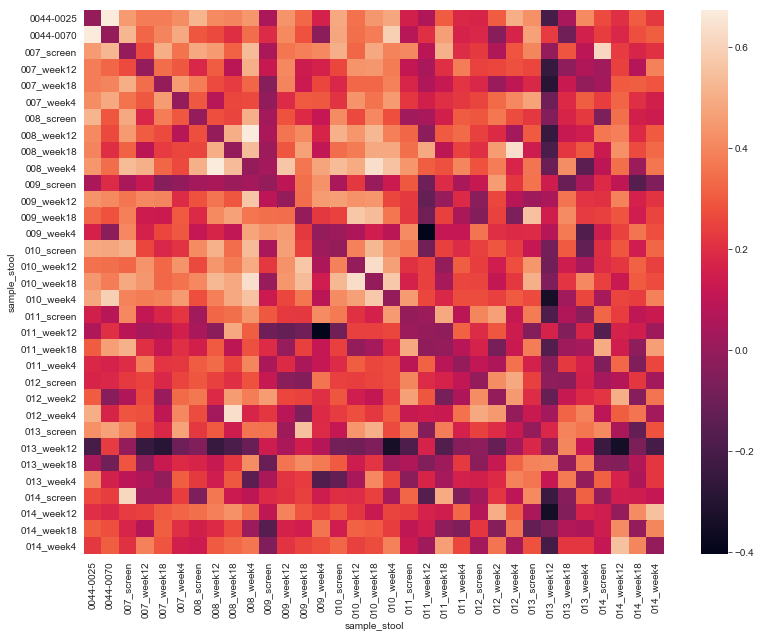

In [51]:
fig = plt.figure(figsize = (13,10))
sns.heatmap(spearman_dists_df.iloc[:33, :33])

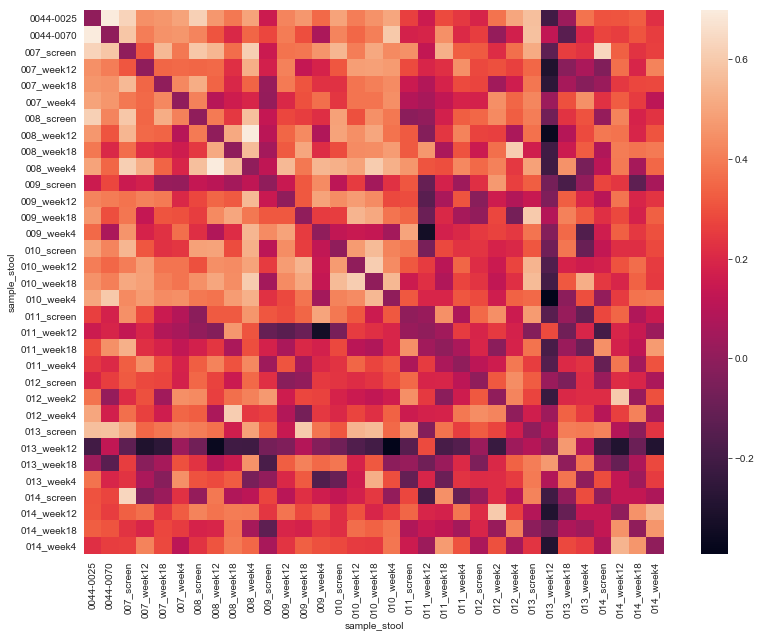

In [52]:
fig = plt.figure(figsize = (13,10))
sns.heatmap(pearson_dists_df.iloc[:33, :33])

### Plot different categories of comparisons

1. Between patient baselines
2. Between donor and patients baselines
3. Within placebo patient before and after ABX
4. Within FMT patient before and after FMT
5. Within placebo patient after ABX
6. Within FMT patient after FMT
7. Between placebo patients after ABX
8. Between FMT patients after ABX

In [112]:
#make comparison buckets
dnr_md = md_iga.loc[md_iga['patient'] == '0044']
dnr_md = dnr_md[['sample_stool', 'patient', 'patient_donor']].drop_duplicates()
dnr_md = dnr_md.rename(columns={'sample_stool': 'sample_id'})
tmp_md = md.loc[md['sample_id'].isin(spearman_dists_df.columns)]
tmp_md = pd.concat([tmp_md, dnr_md], sort=False)

#patient baseline samples
bl_samples = tmp_md.loc[tmp_md['days_past_fmt'] < -5]['sample_id'].values
patbl = list(itertools.combinations(bl_samples, 2))

#donor versus baseline patients
dnr_samples = tmp_md.loc[tmp_md['patient'] == '0044']['sample_id'].values
dnr_patbl = list(itertools.product(dnr_samples, bl_samples))

#within placebo before and after
win_plc_bl_post = []
#within FMT before and after
win_fmt_bl_post = []
#within placebo after
win_plc_post = []
#within fmt after
win_fmt_post = []
#post abx samples
plc_pabx_sams = []
#post fmt samples
fmt_pfmt_sams = []
for patient, sub_df in tmp_md.groupby('patient'):
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]['sample_id'].values
    ptreat = sub_df.loc[sub_df['days_past_fmt'] > 0]['sample_id'].values
    if 'placebo' in sub_df['treatment'].values:
        win_plc_bl_post.extend(list(itertools.product(bl, ptreat)))
        win_plc_post.extend(list(itertools.combinations(ptreat, 2)))
        plc_pabx_sams.append(list(ptreat))
    elif 'fmt' in sub_df['treatment'].values:
        win_fmt_bl_post.extend(list(itertools.product(bl, ptreat)))
        win_fmt_post.extend(list(itertools.combinations(ptreat, 2)))
        fmt_pfmt_sams.append(ptreat)

#between placebo patients after abx
btw_plc_post = []
for x, y in itertools.combinations(plc_pabx_sams, 2):
    btw_plc_post.extend(list(itertools.product(x, y)))

#between fmt patients after fmt
btw_fmt_post = []
for x, y in itertools.combinations(fmt_pfmt_sams, 2):
    btw_fmt_post.extend(list(itertools.product(x, y)))

In [113]:
#make a dataframe of these value
sam_comp_labels = ['Between patient baselines', 'Between donor and patient baselines',
                   'Within placebo before/after abx',
                   'Within FMT before/after FMT',
                   'Within placebo after abx',
                   'Within FMT after FMT',
                   'Between placebo after abx',
                   'Between FMT after ABX']
sam_comps = [patbl, dnr_patbl, win_plc_bl_post, win_fmt_bl_post,
             win_plc_post, win_fmt_post, btw_plc_post, btw_fmt_post]

#combine
sam_comps_df = []
for label, comps in zip(sam_comp_labels, sam_comps):
    tmp_df = pd.DataFrame(comps, columns=['sample1', 'sample2'])
    tmp_df.loc[:, 'comparison_label'] = label
    sam_comps_df.append(tmp_df)
sam_comps_df = pd.concat(sam_comps_df)

#add correlations
sam_comps_df.loc[:, 'spr_corr'] = sam_comps_df.apply(lambda x: spearman_dists_df.loc[x['sample1'],
                                                                                     x['sample2']],
                                                     axis=1)
sam_comps_df.loc[:, 'prs_corr'] = sam_comps_df.apply(lambda x: pearson_dists_df.loc[x['sample1'],
                                                                                     x['sample2']],
                                                     axis=1)

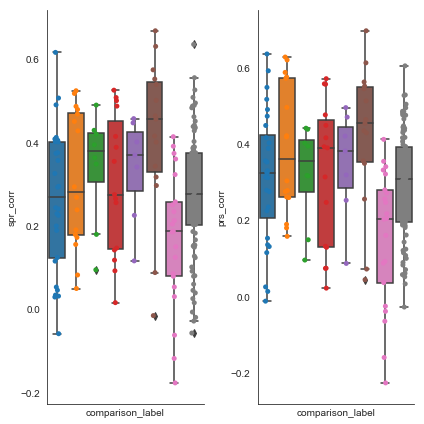

In [76]:
#plot these values
fig = plt.figure(figsize = (6,6))

#do spearman
ax1 = fig.add_subplot(1,2,1)
sns.boxplot(x='comparison_label', y='spr_corr',
            data=sam_comps_df)
sns.stripplot(x='comparison_label', y='spr_corr',
               data=sam_comps_df)
ax1.set_xticks([])

#do pearson
ax2 = fig.add_subplot(1,2,2)
sns.boxplot(x='comparison_label', y='prs_corr',
            data=sam_comps_df)
sns.stripplot(x='comparison_label', y='prs_corr',
               data=sam_comps_df)
ax2.set_xticks([])

sns.despine()
plt.tight_layout()

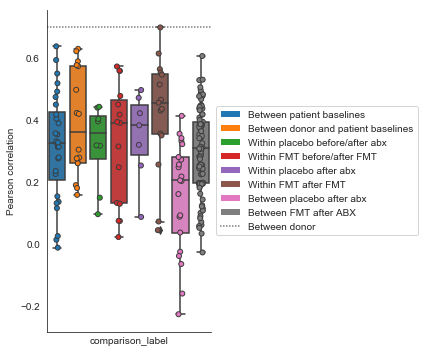

In [92]:
#only do pearson
#do pearson
fig = plt.figure(figsize = (6,5))
ax = sns.boxplot(x='comparison_label', y='prs_corr',
            data=sam_comps_df)
ax = sns.stripplot(x='comparison_label', y='prs_corr',
               data=sam_comps_df, linewidth=1)
ax.set_xticks([])
ax.set_ylabel('Pearson correlation')

legend_elements = [Patch(facecolor=y, label=x) for x, y in zip(sam_comp_labels, sns.color_palette())]
legend_elements.append(Line2D([0], [0], dashes=(1,1), color='grey', label='Between donor'))
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

#add a line for comparison within donor
ax.axhline(pearson_dists_df.loc['0044-0025',
                                '0044-0070'], dashes=(1,1), color='grey')

sns.despine()
plt.tight_layout()

In [117]:
#get correlation between mean of donor values with all other samples
log_chg_ftab.loc[:, 'donor_0044_mean'] = log_chg_ftab[['0044-0025',
                                                       '0044-0070']].mean(axis=1)

donor_0044_mean_spdists = []
for col in log_chg_ftab:
    donor_0044_mean_spdists.append([col, 
                                    spearman_pdist(log_chg_ftab['donor_0044_mean'],
                                                   log_chg_ftab[col])])

In [118]:
#get only engrafted OTUs
d44_pats = ['007', '010', '014']

log_chg_eng = log_chg.loc[log_chg['patient'].isin(d44_pats)]

d44_otus = set(log_chg.loc[log_chg['patient'] == '0044']['#OTU ID'])

eng_otus_res = []
shr_otus_res = []
not_eng_otus_res = []
for patient, sub_df in log_chg_eng.groupby('patient'):
    if patient == '0044':
        continue
    
    #get engrafted OTUs
    bl_otus = set(sub_df.loc[sub_df['days_past_fmt'] < 0]['#OTU ID'])
    pfmt_otus = set(sub_df.loc[sub_df['days_past_fmt'] > 0]['#OTU ID'])
    eng_otus = (pfmt_otus & d44_otus) - bl_otus
    
    #get a dataframe of only engrafted OTUS
    out_df = sub_df.loc[sub_df['#OTU ID'].isin(eng_otus)]
    out_df.loc[:, 'patient'] = patient
    out_df = out_df[['#OTU ID', 'sample_stool', 'patient',
                     'rel_abun_mean', 'log2_fold_chg_abun']].drop_duplicates()
    
    eng_otus_res.append(out_df)
    
    #get shared otus
    shr_otus = bl_otus & d44_otus
    out_df = sub_df.loc[sub_df['#OTU ID'].isin(shr_otus)]
    out_df.loc[:, 'patient'] = patient
    out_df = out_df[['#OTU ID', 'sample_stool', 'patient',
                     'rel_abun_mean', 'log2_fold_chg_abun']].drop_duplicates()
    shr_otus_res.append(out_df)
    
    #get everything that isn't engrafted
    out_df = sub_df.loc[~sub_df['#OTU ID'].isin(eng_otus)]
    out_df.loc[:, 'patient'] = patient
    out_df = out_df[['#OTU ID', 'sample_stool', 'patient',
                     'rel_abun_mean', 'log2_fold_chg_abun']].drop_duplicates()
    not_eng_otus_res.append(out_df)

eng_otus_res_df = pd.concat(eng_otus_res)
shr_otus_res_df = pd.concat(shr_otus_res)
not_eng_otus_res_df = pd.concat(not_eng_otus_res)

In [119]:
#make a feature table
eng_otus_ftab = eng_otus_res_df.pivot(index='#OTU ID',
                                      columns='sample_stool',
                                      values='log2_fold_chg_abun')
eng_otus_ftab = eng_otus_ftab.merge(log_chg_ftab[['donor_0044_mean']], 
                                    left_index=True,
                                    right_index=True,
                                    how='outer')

not_eng_ftab = not_eng_otus_res_df.pivot(index='#OTU ID',
                                      columns='sample_stool',
                                      values='log2_fold_chg_abun')
not_eng_ftab = not_eng_ftab.merge(log_chg_ftab[['donor_0044_mean']], 
                                    left_index=True,
                                    right_index=True,
                                    how='outer')

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:765: RuntimeWarning: '<' not supported between instances of 'str' and 'float', sort order is undefined for incomparable objects
  sort=self.sort)


In [120]:
#get correlation between mean of donor values with engrafted samples
d44_mean_eng_spdists = []
for col in eng_otus_ftab:
    d44_mean_eng_spdists.append([col, 
                                        spearman_pdist(eng_otus_ftab['donor_0044_mean'],
                                                       eng_otus_ftab[col])])

d44_mean_not_eng_spdists = []
for col in not_eng_ftab:
    d44_mean_not_eng_spdists.append([col, 
                                     spearman_pdist(not_eng_ftab['donor_0044_mean'],
                                                    not_eng_ftab[col])])

#get correlation between mean of donor values with engrafted samples
d44_mean_eng_prdists = []
for col in eng_otus_ftab:
    d44_mean_eng_prdists.append([col, 
                                        pearson_pdist(eng_otus_ftab['donor_0044_mean'],
                                                      eng_otus_ftab[col])])

d44_mean_not_eng_prdists = []
for col in not_eng_ftab:
    d44_mean_not_eng_prdists.append([col, 
                                     pearson_pdist(not_eng_ftab['donor_0044_mean'],
                                                   not_eng_ftab[col])])

In [121]:
def xval_name(x):
    if x['approx_wk'] < 0:
        return 'baseline'
    else:
        return f"{x['treatment']} week {int(x['approx_wk'])}"

In [122]:
#make dataframes for plotting
d44_mean_sprm_df = pd.DataFrame(donor_0044_mean_spdists,
                                columns=['sample_id', 'd44_sprm_corr']).merge(md)
#add x-axis
d44_mean_sprm_df.loc[:, 'x_val'] = d44_mean_sprm_df.apply(xval_name, axis=1)

d44_mean_sprm_df = d44_mean_sprm_df.sort_values(['patient', 'approx_wk'])
d44_mean_sprm_df.loc[:, 'patient_plt'] = 'patient_' + d44_mean_sprm_df['patient']

#get the engraftment plot dfs
tmp = pd.DataFrame(d44_mean_eng_spdists,
                   columns=['sample_id', 'd44_sprm_corr'])
tmp.loc[:, 'engrafted'] = 'engrafted'
tmp1 = pd.DataFrame(d44_mean_not_eng_spdists,
                   columns=['sample_id', 'd44_sprm_corr'])
tmp1.loc[:, 'engrafted'] = 'not engrafted'

d44_eng_sprm_df = pd.concat([tmp, tmp1]).merge(md)
d44_eng_sprm_df.loc[:, 'patient_plt'] = 'patient_' + d44_eng_sprm_df['patient']

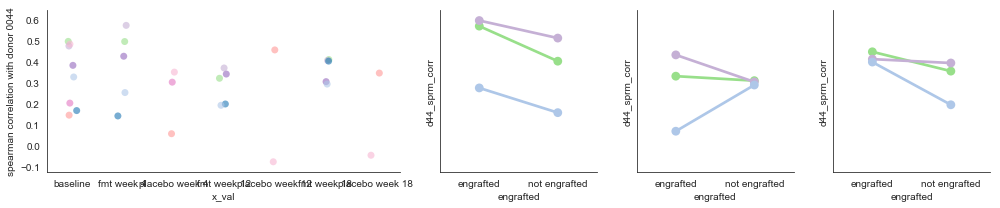

In [500]:
fig = plt.figure(figsize = (14,3))

ax1 = plt.subplot2grid((1, 10), (0, 0), colspan=4)
sns.stripplot(x='x_val', y='d44_sprm_corr', 
              data=d44_mean_sprm_df.loc[d44_mean_sprm_df['approx_wk'] != 2],
              order=['baseline', 'fmt week 4', 'placebo week 4',
                     'fmt week 12', 'placebo week 12',
                     'fmt week 18', 'placebo week 18'],
             hue='patient_plt', palette=dd_pat_col_name,
             size=7, alpha=0.6)
ax1.set_ylabel('spearman correlation with donor 0044')
ax1.legend_.remove()

ax2 = plt.subplot2grid((1, 10), (0, 4), colspan=2, sharey=ax1)
sns.pointplot(x='engrafted', y='d44_sprm_corr',
              hue='patient_plt',
              data=d44_eng_sprm_df.loc[d44_eng_sprm_df['approx_wk'] == 4], 
              palette=dd_pat_col_name)
ax2.legend_.remove()

ax3 = plt.subplot2grid((1, 10), (0, 6), colspan=2, sharey=ax1)
sns.pointplot(x='engrafted', y='d44_sprm_corr',
              hue='patient_plt',
              data=d44_eng_sprm_df.loc[d44_eng_sprm_df['approx_wk'] == 12], 
              palette=dd_pat_col_name)
ax3.legend_.remove()

ax4 = plt.subplot2grid((1, 10), (0, 8), colspan=2, sharey=ax1)
sns.pointplot(x='engrafted', y='d44_sprm_corr',
              hue='patient_plt',
              data=d44_eng_sprm_df.loc[d44_eng_sprm_df['approx_wk'] == 18], 
              palette=dd_pat_col_name)
ax4.legend_.remove()

#remove redundant y values
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
#plt.setp(ax2.get_ylabel(), visible=False)
#plt.setp(ax3.get_ylabel(), visible=False)
#plt.setp(ax4.get_ylabel(), visible=False)

sns.despine()
plt.tight_layout()

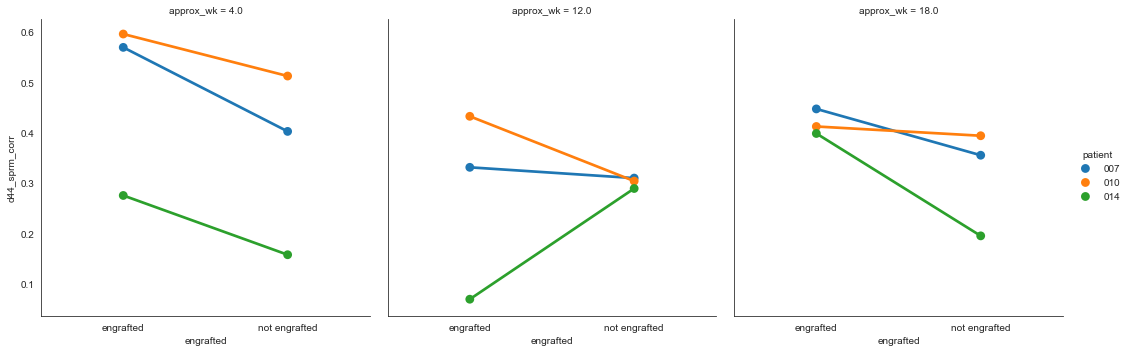

In [464]:
#plot all baseline against donor
fig = plt.figure(figsize = (14,3))

for patient, sub_df in d44_mean_sprm_df.loc[d44_mean_sprm_df['approx_wk'] < 0].groupby('patient'):
    ax = fig.add_subplot(4,2,1)
    

In [123]:
#get plotting dfs for pearson correlation
tmp_eng = pd.DataFrame(d44_mean_eng_prdists,
                       columns=['sample_id', 'd44_pear_corr']).merge(md)
tmp_eng.loc[:, 'engrafted'] = 'engrafted'
tmp_noeng = pd.DataFrame(d44_mean_not_eng_prdists,
                       columns=['sample_id', 'd44_pear_corr']).merge(md)
tmp_noeng.loc[:, 'engrafted'] = 'shared'

#make df
eng_v_noeng_df = pd.concat([tmp_eng, tmp_noeng])
eng_v_noeng_df.loc[:, 'patient_plt'] = 'patient_' + eng_v_noeng_df['patient']


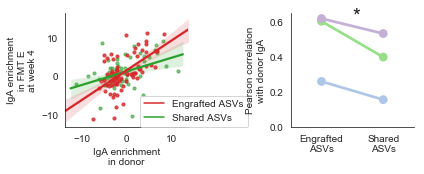

In [126]:
#plot correlations of patient 007
fig = plt.figure(figsize = (6,2.5))

#ax1 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,1)
sns.regplot(x=not_eng_ftab['donor_0044_mean'],
            y=not_eng_ftab['007_week4'],
            scatter_kws={'s': 10, 'alpha': 0.6},
            color=sns.color_palette()[2])
sns.regplot(x=eng_otus_ftab['donor_0044_mean'],
            y=eng_otus_ftab['007_week4'], 
            scatter_kws={'s': 10},
            color=sns.color_palette()[3])

ax1.set_yticks([-10, 0, 10])
ax1.set_xlabel('IgA enrichment\nin donor')
ax1.set_ylabel('IgA enrichment\nin FMT E\nat week 4')

legend_elements = [Line2D([0], [0], color=sns.color_palette()[3], label='Engrafted ASVs'),
                   Line2D([0], [0], color=sns.color_palette()[2], label='Shared ASVs')]
ax1.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(.57, 0.14))

ax2 = fig.add_subplot(1,2,2)
sns.pointplot(x='engrafted', y='d44_pear_corr',
              hue='patient_plt',
              data=eng_v_noeng_df.loc[eng_v_noeng_df['approx_wk'] == 4], 
              palette=dd_pat_col_name)
ax2.set_xlabel('')
plt.xticks([0, 1], ['Engrafted\nASVs', 'Shared\nASVs'])
ax2.set_ylabel('Pearson correlation\nwith donor IgA')
ax2.set_ylim(0,None)
ax2.legend_.remove()
ax2.annotate('*', xy=(0.5, 0.6), size=20)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/pat007_engvshared_igacorr_2019-04-17.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/pat007_engvshared_igacorr_2019-04-17.pdf',
            dpi=300)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


(0, 0.6473953997972465)

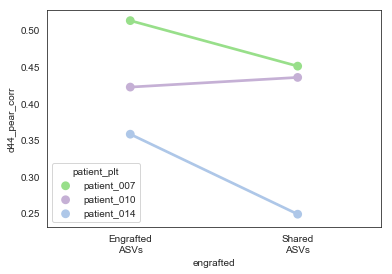

In [636]:
ax2 = fig.add_subplot(1,2,2)
sns.pointplot(x='engrafted', y='d44_pear_corr',
              hue='patient_plt',
              data=eng_v_noeng_df.loc[eng_v_noeng_df['approx_wk'] == 18], 
              palette=dd_pat_col_name)
ax2.set_xlabel('')
plt.xticks([0, 1], ['Engrafted\nASVs', 'Shared\nASVs'])
ax2.set_ylabel('Pearson correlation\nwith donor IGA')
ax2.set_ylim(0,None)

### Plotting correlations with baseline samples

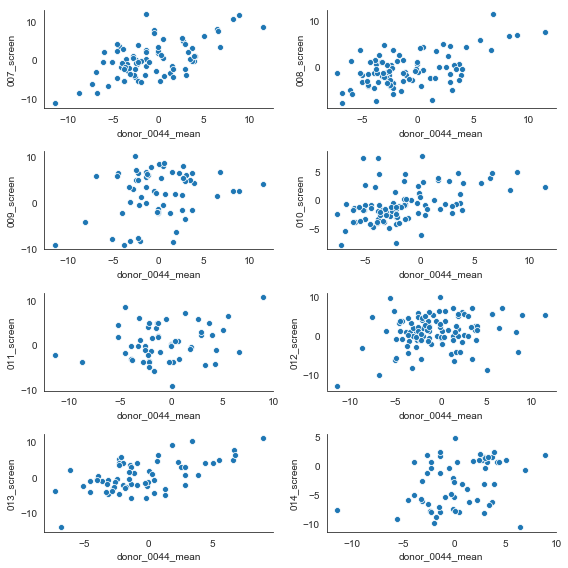

In [510]:
#plot these correlations with the baseline samples
md_tmp = md_iga.loc[md_iga['approx_wk'] < 0]
bl_samples = list(md_tmp['sample_stool'].unique())

fig = plt.figure(figsize = (8,8))

counter = 1
for sample in bl_samples:
    ax = fig.add_subplot(4,2,counter)
    sns.scatterplot(x='donor_0044_mean', y=sample,
                    data=log_chg_ftab)
    
    counter += 1

sns.despine()
plt.tight_layout()

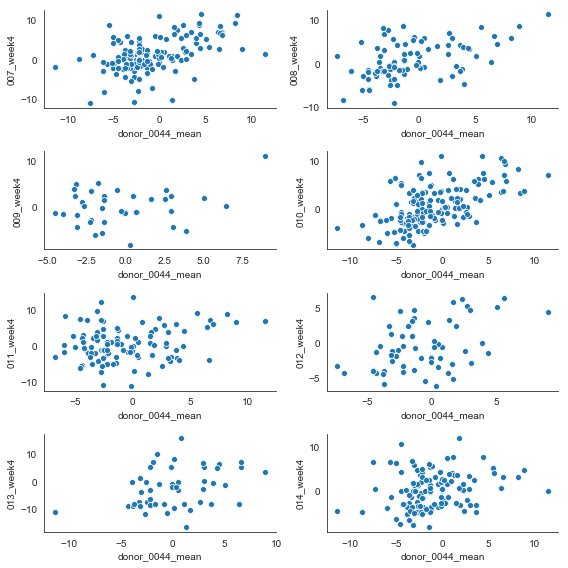

In [638]:
#plot these correlations with the week 4 samples
md_tmp = md_iga.loc[md_iga['approx_wk'] == 4]
w4_samples = list(md_tmp['sample_stool'].unique())

fig = plt.figure(figsize = (8,8))

counter = 1
for sample in w4_samples:
    ax = fig.add_subplot(4,2,counter)
    sns.scatterplot(x='donor_0044_mean', y=sample,
                    data=log_chg_ftab)
    
    counter += 1

sns.despine()
plt.tight_layout()

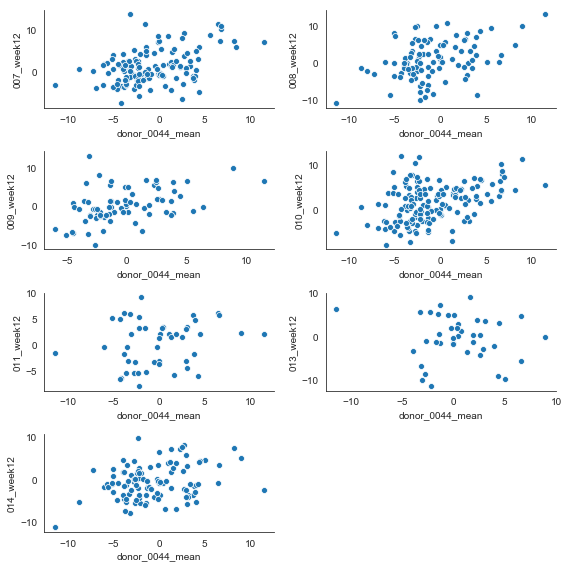

In [639]:
#plot these correlations with the week 4 samples
md_tmp = md_iga.loc[md_iga['approx_wk'] == 12]
w12_samples = list(md_tmp['sample_stool'].unique())

fig = plt.figure(figsize = (8,8))

counter = 1
for sample in w12_samples:
    ax = fig.add_subplot(4,2,counter)
    sns.scatterplot(x='donor_0044_mean', y=sample,
                    data=log_chg_ftab)
    
    counter += 1

sns.despine()
plt.tight_layout()

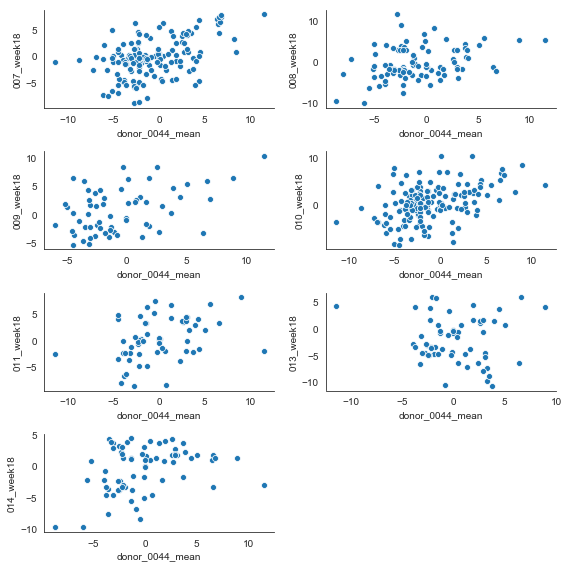

In [640]:
#plot these correlations with the week 4 samples
md_tmp = md_iga.loc[md_iga['approx_wk'] == 18]
w18_samples = list(md_tmp['sample_stool'].unique())

fig = plt.figure(figsize = (8,8))

counter = 1
for sample in w18_samples:
    ax = fig.add_subplot(4,2,counter)
    sns.scatterplot(x='donor_0044_mean', y=sample,
                    data=log_chg_ftab)
    
    counter += 1

sns.despine()
plt.tight_layout()

## Get biomodality for all OTUs

Let's get the Diptest statistic of modality for all OTUs from the 16S samples. We'll have to do this in R, since there isn't a good module for this in python.

We'll get the bimodality over all patients, and then compare this to the mean IGA enrichment.

In [ ]:
library('diptest')

In [ ]:
#read in data
iga_16s <- read.table('/Users/ndchu/Documents/uc_fmt/iga_seq/iga_16S/otu_tab_f.tsv',
                      header=TRUE, comment.char="", row.names=1, sep='\t')

md_iga <- read.table('/Users/ndchu/Documents/uc_fmt/metadata/metadata_iga_OC162018.tsv',
                    header=TRUE, sep='\t')
md <- read.table('/Users/ndchu/Documents/uc_fmt/metadata/metadata_stool_dna_NV022018.tsv',
                 header=TRUE, sep='\t')

In [515]:
#convert to relative abundance
iga_16s_ra <- scale(iga_16s, center=FALSE, scale=colSums(iga_16s))

In [ ]:
#subset for only the 16S columns
sam_16s <- md[,'sample_mimarks']
sub_16s_ra <- iga_16s_ra[,sam_16s]

In [ ]:
#caluculate diptest over each row
dip_ra <- apply(sub_16s_ra, 1, dip.test)
dip_stat <- apply(sub_16s_ra, 1, dip)

#extract the p values from each of these entries
dip_p <- sapply(dip_ra, function(x) x$p.value)

In [ ]:
#write these to files
write.table(dip_stat, 
            file='/Users/ndchu/Documents/uc_fmt/iga_seq/iga_16S/dip_test_stat.tsv',
            sep='\t')

write.table(dip_p, 
            file='/Users/ndchu/Documents/uc_fmt/iga_seq/iga_16S/dip_test_p.tsv',
            sep='\t')

In [30]:
#now we can read this into python
dip_stat = pd.read_csv('/Users/ndchu/Documents/uc_fmt/iga_seq/iga_16S/dip_test_stat.tsv',
                       sep='\t').rename(columns={'x': 'dip_stat'})
dip_p = pd.read_csv('/Users/ndchu/Documents/uc_fmt/iga_seq/iga_16S/dip_test_p.tsv',
                       sep='\t').rename(columns={'x': 'dip_p'})

#combine
dip_df = pd.concat([dip_stat, dip_p], axis=1)
dip_df = dip_df.reset_index().rename(columns={'index': '#OTU ID'})

In [31]:
#get average IGA over all patients, and also over all samples
iga_mean_allsam = log_chg_cl.groupby('#OTU ID')['log2_fold_chg_abun'].mean().reset_index()
iga_med_allsam = log_chg_cl.groupby('#OTU ID')['log2_fold_chg_abun'].median().reset_index()
iga_mean_allpat = log_chg_cl.groupby(['patient', 
                                      '#OTU ID'])['log2_fold_chg_abun'].mean().reset_index()
iga_mean_allpat = iga_mean_allpat.groupby('#OTU ID').mean().reset_index()


#merge with log chg IGA label data
dip_iga_df = dip_df.merge(iga_mean_allsam)

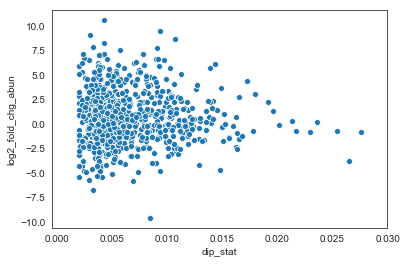

In [32]:
#plot 
sns.scatterplot(x='dip_stat', y='log2_fold_chg_abun',
                data=dip_iga_df)

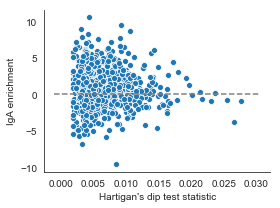

In [34]:
#plot abundance versus IGA
fig = plt.figure(figsize = (4,3))

ax1 = fig.add_subplot(1,1,1)
sns.scatterplot(x='dip_stat', y='log2_fold_chg_abun', 
                data=dip_iga_df)
ax1.plot(ax1.get_xlim(), [0, 0], 
         color='grey', ls='--')

ax1.set_xlabel("Hartigan's dip test statistic")
ax1.set_ylabel('IgA enrichment')

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/iga_diptest_2019-05-06.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/iga_diptest_2019-05-06.pdf',
            dpi=300)

In [6]:
#read in the IGA+/– labels
itol_out_df = pd.read_csv('/Users/ndchu/Documents/uc_fmt/iga_seq/itol/2019-03-05.binary_category_viz/binary_iga_categories_data.txt',
                          header=None, names=['IGA+_patients', 'IGA+_samples', 'IGA–_patients',
                                                'IGA–_samples', 'Variable_across_patients', 
                                                'Variable_within_patients', 'Neutral'])

## Different engraftment patterns depending on IGA

1. Do IGA+/– organisms in the donor have a better or worse chance of engrafting?
2. Do IGA+/– organisms at week 4 have a greater chance of sticking around until week 12 or 18?

For 1, we'll categorize OTUs into IGA+ in both samples, IGA– in both samples, mixed across samples, or IGA neutral in both samples.

For engraftment, we'll want to consider (a) novel engraftment and (b) simple presence after fmt, which may mean engraftment or a mix of strains.

In [10]:
def std_dev_interval(value, mean, std):
    """
    returns 'pos' if a value is greater than mean - 1 std dev
            'neg' if a value is less than mean - 1 std dev
            'None' if a value is within mean +/- 1 std dev
    """
    if value >= mean + std:
        return 'pos'
    elif value <= mean - std:
        return 'neg'
    else:
        return None

In [11]:
# get IGA enrichment dataframe for the donor
tmp = log_chg_iga_16s[['#OTU ID', 'sample_mimarks', 'log2_fold_chg_abun']]
tmp = tmp.loc[~tmp['sample_mimarks'].str.startswith('POS')]
tmp = tmp.loc[~tmp['sample_mimarks'].str.startswith('NEG')]
tmp['sample_mimarks'] = tmp['sample_mimarks'].str[:-4]
tmp = tmp.drop_duplicates()
log_chg_iga_16s_ftab = tmp.pivot(index='#OTU ID', 
                                 columns='sample_mimarks',
                                 values='log2_fold_chg_abun')
d44_log_chg = log_chg_iga_16s_ftab[['0044.0025', '0044.0070']].dropna(how='all')

#get mean and std dev for each sample
s1_sign = d44_log_chg['0044.0025'].apply(std_dev_interval, 
                                         mean=d44_log_chg['0044.0025'].mean(),
                                         std=d44_log_chg['0044.0025'].std())
s2_sign = d44_log_chg['0044.0070'].apply(std_dev_interval, 
                                         mean=d44_log_chg['0044.0070'].mean(),
                                         std=d44_log_chg['0044.0070'].std())
log_chg_sign = pd.concat([s1_sign, s2_sign], axis=1)

#get OTU groups
pos_otus = set(log_chg_sign.loc[(log_chg_sign == 'pos').all(axis=1)].index)
neg_otus = set(log_chg_sign.loc[(log_chg_sign == 'neg').all(axis=1)].index)
neu_otus = set(log_chg_sign.loc[(log_chg_sign.isnull()).all(axis=1)].index)
mix_otus = set(log_chg_sign.index) - pos_otus - neg_otus - neu_otus

In [30]:
#of these otus, which ones engraft in patients?
iga_16s_tidy_only16s = iga_16s_tidy.loc[iga_16s_tidy['gate'].isnull()]
iga_16s_tidy_only16s = iga_16s_tidy_only16s.loc[iga_16s_tidy_only16s['count'] > 0]

d44_otus = set(iga_16s_tidy_only16s.loc[iga_16s_tidy_only16s['patient'] == '0044']['#OTU ID'])

otu_cat_store = []
#get engrafted otus for d44 patients
for patient, sub_df in iga_16s_tidy_only16s.groupby('patient'):
    if patient not in ['001', '007', '010', '014']:
        continue
    
    bl_df = sub_df.loc[sub_df['days_past_fmt'] < -5]
    pfmt_df = sub_df.loc[sub_df['days_past_fmt'] > 0]
    flup_df = sub_df.loc[sub_df['days_past_fmt'] > 100]
    
    #get otus in baseline
    bl_otus = set(bl_df['#OTU ID'])
    for x in bl_otus:
        otu_cat_store.append([patient, x, 'baseline'])
    
    #get bacteria in at least 3 pfmt samples
    tmp = pfmt_df.groupby('#OTU ID').size()
    pfmt_otus = set(tmp.loc[tmp >= 3].index)
    for x in pfmt_otus:
        otu_cat_store.append([patient, x, 'pfmt'])
    
    #get baceria present in any follow up sample
    flup_otus = set(flup_df['#OTU ID'])
    for x in flup_otus:
        otu_cat_store.append([patient, x, 'follow_up'])
    
    #get bacteria that appear to engraft
    eng_otus = (pfmt_otus & d44_otus) - bl_otus
    for x in eng_otus:
        otu_cat_store.append([patient, x, 'engrafted'])

otu_cat_df = pd.DataFrame(otu_cat_store, 
                          columns=['patient', '#OTU ID', 'category'])

In [31]:
#now look at the frequency of different IgA groups
pos_group_df = otu_cat_df.loc[otu_cat_df['#OTU ID'].isin(pos_otus)]
neg_group_df = otu_cat_df.loc[otu_cat_df['#OTU ID'].isin(neg_otus)]
neu_group_df = otu_cat_df.loc[otu_cat_df['#OTU ID'].isin(neu_otus)]
mix_group_df = otu_cat_df.loc[otu_cat_df['#OTU ID'].isin(mix_otus)]

In [35]:
pos_group_df.groupby(['patient', 'category']).size().reset_index()

,patient,category,0
0,001,baseline,4
1,001,follow_up,3
2,001,pfmt,3
3,007,baseline,7
4,007,engrafted,3
5,007,follow_up,8
6,007,pfmt,8
7,010,baseline,5
8,010,engrafted,4
9,010,follow_up,7


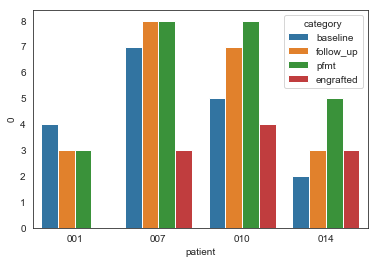

In [36]:
sns.barplot(x='patient', y=0, hue='category',
           data = pos_group_df.groupby(['patient', 
                                        'category']).size().reset_index())

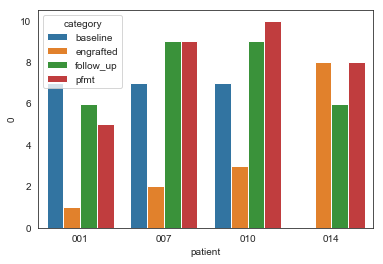

In [37]:
sns.barplot(x='patient', y=0, hue='category',
           data = neg_group_df.groupby(['patient', 
                                        'category']).size().reset_index())

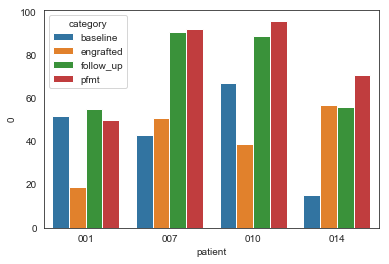

In [38]:
sns.barplot(x='patient', y=0, hue='category',
           data = neu_group_df.groupby(['patient', 
                                        'category']).size().reset_index())

In [26]:
neu_group_df.groupby(['patient', 'category']).size()

patient  category 
001      engrafted    19
         follow_up    55
         pfmt         50
007      engrafted    51
         follow_up    91
         pfmt         92
010      engrafted    39
         follow_up    89
         pfmt         96
014      engrafted    57
         follow_up    56
         pfmt         71
dtype: int64

## Expected number of IgA+/– bacteria

In a null world, how many reliably IgA+ and IgA- bacteria do we expect?

We'll look at this without any assumptions by simply shuffling the labels and seeing what comes out.

In [76]:
def relative_abundance_tidy(df, sample_col, value_col,
                            rel_abun_name='rel_abun'):
    """
    Take a tidy table, where the samples are in sample_col and the values
    to be converted to relative abundance are in value_col.
    
    sample_col can also be a list of columns
    """
    #define relatibe abundance calculation
    rel_abun = lambda x: (x / x.sum())
    #calculate new values
    values = df.groupby(sample_col)[value_col].transform(rel_abun)
    values = values.rename(rel_abun_name)
    #add to df and return
    df = pd.concat([df, values], axis=1)
    return df

def diff_tidy(df, index_col, var_col, value_col,
              var_ord, diff_name='diff'):
    """
    Takes a tidy dataframe and returns difference between two variables.
    
    The change calculated is determined by the column names provided.
    The input tidy dataframe is first turned into a feature table,
    across which the difference is calculated.
    
    index_col: column to use as the feature table index
    var_col: column to use as the variable names (feature table columns)
    value_col: column to use as the values of the feature table
    var_ord: {list} provides the order of the variables for the difference
        calculation. 
        
        I.e. **if the var_ord = ['A', 'B'] then the difference is
        calculated as A - B**. 
        
        This value can be a subset of those values in
        var_col
    dif_name: the name for the resulting series
    """
    piv_df = df.pivot(index=index_col, columns=var_col, values=value_col)
    #calculate difference
    diff = (piv_df[var_ord[0]] - piv_df[var_ord[1]]).rename(diff_name)
    #make a like-indexed object
    piv_df = df.merge(diff.to_frame(), left_on=index_col, right_index=True)
    return piv_df.reset_index(drop=True)

In [77]:
#starting from the original +/– ftabs, shuffle OTU labels within each sample
def df_shuffle_within(df, axis=0):
    """
    Shuffles the values in each column or row
    
    If axis = 0, then values across columns will be shuffled,
    meaning that columns will retain the same sum value
    
    If axis = 1, then values across rows will be shuffled,
    meaning that rows will retain the same sum value
    """
    out_df = df.apply(np.random.permutation, axis=axis)
    
    return out_df

def iga_log_chg(df):
    """
    Given a feature table from this dataset, calculates log fold
    change for each otu with a pseudo count of 0.5
    """
    df_psct = df + 0.5
    

#### Do we need to account for the fact that many absent otus are dilutin the reads that tend to cluster in the same otus in the data?

In [78]:
#get 1000 shuffled tables
iga_psct = iga + 0.5
sam_pass = md_iga.loc[md_iga['gate'].notnull()]['sample_iga_stool'] #keep noncontrol
iga_psct = iga_psct[sam_pass.tolist()]
shuffles = [df_shuffle_within(iga_psct) for x in range(100)]

#get tidy dataframes for all of these tables
tidy_shuffles = []
for df in shuffles:
    #make into tidy data
    tidy_df = pd.melt(df.reset_index(),
                      id_vars='#OTU ID',
                      var_name='sample_iga_stool',
                      value_name='ps_count')
    
    #get relative abundance
    tidy_df = relative_abundance_tidy(tidy_df, 'sample_iga_stool', 
                                      'ps_count', rel_abun_name='rel_abun_psct')
    
    #get log 2 values
    tidy_df.loc[:, 'log2_abun_psct'] = np.log2(tidy_df['rel_abun_psct'])
    
    #add metadata
    tidy_df = tidy_df.merge(md_iga)
    
    #store the table
    tidy_shuffles.append(tidy_df)

#now calculate the log fold change for each otu in each sample
log_chg_dfs = [] #collect results for each df
for df in tidy_shuffles:
    res = [] #collect results for each sample x otu combination
    for [sample, otu], sub_df in df.groupby(['sample_stool', '#OTU ID']):
        tmp_series = pd.Series(sub_df['log2_abun_psct'].values,
                               index=sub_df['gate'])
        res.append([sample, otu, tmp_series['pos'] - tmp_series['neg']])
    #make into a dataframe
    res_df = pd.DataFrame(res, columns=['sample_stool', '#OTU ID', 'log2_fold_chg_abun'])
    log_chg_dfs.append(res_df)

In [80]:
##now calculate how many reliably IgA + and IgA– we get
fdr_res = []
for df in log_chg_dfs:
    df = df.merge(md_iga_flat)
    
    #get mean per patient
    patmean = df.groupby(['#OTU ID', 'patient']).mean().reset_index()
    
    #test each otu
    ttest_cat_ppat = patmean.groupby('#OTU ID')['log2_fold_chg_abun'].apply(ttest_zero_vals).reset_index()

    ttest_cat_ppat = ttest_cat_ppat.rename(columns={'level_1': 'var', 
                                          'log2_fold_chg_abun': 'value'})
    ttest_cat_ppat = ttest_cat_ppat.pivot(index='#OTU ID', columns='var', values='value')
    #drop nans
    ttest_cat_ppat = ttest_cat_ppat.loc[ttest_cat_ppat['p'].notnull()]
    #get FDR adjusted pvalues
    ttest_cat_ppat.loc[:, 'fdr'] = multitest.fdrcorrection(ttest_cat_ppat['p'])[1]
    
    fdr_res.append(ttest_cat_ppat)

#how many pass FDR < 0.1?
fdr_ct = [df.loc[df['fdr'] < 0.1].shape for df in fdr_res]

In [ ]:
#how many did we find in the data?
itol_out_df = pd.read_csv('/Users/ndchu/Documents/uc_fmt/iga_seq/itol/2019-03-05.binary_category_viz/binary_iga_categories_data.txt',
                          header=None, names=['IGA+_patients',
                                                'IGA+_samples', 
                                                'IGA–_patients',
                                                'IGA–_samples',
                                                'Variable_across_patients',
                                                'Variable_within_patients',
                                                'Neutral'])

(itol_out_df == 1).sum()

In [81]:
fdr_ct

[(0, 3),
 (0, 3),
 (0, 3),
 (1, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (1, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (1, 3)]

## IgA-seq bugs that transfer

Let's get this information. We'll call any bug absent from both IgA+ and IgA– before FMT and present in at least 2 time points after and present in the donor as transferred

In [12]:
log_chg_cl.head()

,#OTU ID,sample_stool,log2_fold_chg_abun,patient,patient_donor,days_past_fmt,approx_wk,treatment,fmt_induction,clinical_response
0,33518e48b174ac428cb7be1a216c6c6e,0044-0025,-1.864271,0044,donor,NaN,NaN,NaN,NaN,NaN
1,c67445ed68d61f49e41b7bdd1de019fb,0044-0025,-4.645793,0044,donor,NaN,NaN,NaN,NaN,NaN
2,6afbda63b0750231cd586b402d745cd8,0044-0025,5.663683,0044,donor,NaN,NaN,NaN,NaN,NaN
3,0243b68c76049aa1b8c51a20333da950,0044-0025,2.864919,0044,donor,NaN,NaN,NaN,NaN,NaN
4,b621d4b3cca1ec89ceca12efca8a94fb,0044-0025,-1.071944,0044,donor,NaN,NaN,NaN,NaN,NaN


In [23]:
d44_otus = set(log_chg_cl.loc[log_chg_cl['patient'] == '0044']['#OTU ID'])

trans_otus_res = []

for patient, sub_df in log_chg_cl.groupby('patient'):
    if patient not in ['007', '008', '010', '011', '014']:
        continue
    #get baseline otus
    bl_otus = set(sub_df.loc[sub_df['days_past_fmt'] < 0]['#OTU ID'])
    
    #get otus in at least 2 samples after fmt
    pfmt_otu_counts = sub_df.loc[sub_df['days_past_fmt'] > 0]['#OTU ID'].value_counts()
    s2_otus = set(pfmt_otu_counts.loc[pfmt_otu_counts >= 2].index)
    
    #get transferred otus
    trans_otus = (s2_otus & d44_otus) - bl_otus
    
    for otu in trans_otus:
        trans_otus_res.append([patient, otu])

trans_otus_df = pd.DataFrame(trans_otus_res, columns=['patient', '#OTU ID'])

In [35]:
trans_otus_set = trans_otus_df['#OTU ID'].unique()

In [25]:
df = pd.read_csv('/Users/ndchu/Downloads/tmp.txt',
                 sep='\t')

In [36]:
df.loc[:, 'observed_transfer_in_1+_fmt_patients'] = [x in trans_otus_set for x in df['#OTU ID'].values]

In [38]:
df.to_csv('/Users/ndchu/Downloads/tmp.txt',
          sep='\t', index=False)